In [74]:
from dotenv import load_dotenv
load_dotenv()
import os

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen-2.5-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result


AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.003682899, 'queue_time': 0.09588796599999999, 'total_time': 0.053682899}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_c527211fd1', 'finish_reason': 'stop', 'logprobs': None}, id='run-db8c50bc-066a-429f-ae10-74d6f1caa155-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

In [75]:
from typing_extensions import TypedDict
from pydantic import BaseModel
from langgraph.graph import add_messages
from typing import Annotated, List, Dict, Any

class BlogState(TypedDict):
    topic: str
    title: str
    blog_content: Annotated[List, add_messages]
    reviewed_content: Annotated[List, add_messages]
    is_blog_ready: str

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

def generate_title(state: BlogState):
    prompt = f"""Generate compelling blog title option about {state["topic"]} that is:
    - SEO-friendly
    - Attention-grabbing
    - Topic-agnostic (works for multiple niches)
    - Between 6-12 words
    """
    
    response = llm.invoke(prompt)
    return {"title": response.content}

def generate_content(state: BlogState):
    prompt = f"""Write a comprehensive blog post titled "{state["title"]}" with:
    1. Engaging introduction with hook
    2. 3-5 subheadings with detailed content
    3. Practical examples/statistics
    4. Clear transitions between sections
    5. Actionable conclusion
    Style: Professional yet conversational (Flesch-Kincaid 60-70)
    Length: 1500-2000 words"""
    
    response = llm.invoke(prompt)
    return {"blog_content": response.content}

def review_content(state: BlogState):
    prompt = f"""Critically review this blog content (scale 1-10):
    - Clarity & Structure
    - Grammar & Style
    - SEO optimization
    - Reader engagement
    Provide specific improvement suggestions. Content:\n{state["blog_content"]}"""
    
    feedback = llm.invoke(prompt)
    
    return {"reviewed_content": feedback.content}

def evaluate_content(state: BlogState):

    # Create evaluation prompt
    prompt = f"""Evaluate blog content against editorial feedback (Pass/Fail):
    
    Original Blog Content:
    {state["blog_content"]}

    Editor Feedback:
    {state["reviewed_content"]}

    Evaluation Criteria:
    1. Coherent structure (logical flow between sections)
    2. Grammar/mechanics (no errors in spelling/punctuation)
    3. Brief compliance (matches topic: {state["topic"]})
    4. Engagement factors (storytelling, examples, hooks)
    5. Formatting (proper headers, lists, whitespace)
    6. Feedback addressed (revisions based on editor comments)

    Final Verdict (Pass = meets all criteria, Fail = any major issues):
    Answer only Pass or Fail:"""

    # Get LLM response
    response = llm.invoke(prompt)
    verdict = response.content.strip().upper()
    
    # Update state
    state["is_blog_ready"] = "Pass" if "PASS" in verdict else "Fail"
    state["reviewed_content"].append(AIMessage(
        content=f"Final Verdict: {state['is_blog_ready']}\n{response.content}"
    ))
    
    return state

def route_based_on_verdict(state: BlogState):
    """Conditional routing function"""
    return "Pass" if state["is_blog_ready"] == "Pass" else "Fail"



def is_content_good(state: BlogState):
    # Extract content from message history
    main_content = "\n".join(
        [msg.content for msg in state["blog_content"] if isinstance(msg, AIMessage)]
    )
    feedback_content = "\n".join(
        [msg.content for msg in state["reviewed_content"] if isinstance(msg, HumanMessage)]
    )

    prompt = f"""Evaluate blog content against editorial feedback (Pass/Fail):
    
    Original Blog Content:
    {main_content}

    Editor Feedback:
    {feedback_content}

    Evaluation Criteria:
    1. Coherent structure (logical flow between sections)
    2. Grammar/mechanics (no errors in spelling/punctuation)
    3. Brief compliance (matches topic: {state["topic"]})
    4. Engagement factors (storytelling, examples, hooks)
    5. Formatting (proper headers, lists, whitespace)
    6. Feedback addressed (revisions based on editor comments)

    Final Verdict (Pass = meets all criteria, Fail = any major issues):
    Answer only Pass or Fail:"""

    # Get response content from AIMessage
    response = llm.invoke(prompt)
    verdict = response.content.strip().upper()  # Extract content before processing
    
    state["is_blog_ready"] = "Pass" if "PASS" in verdict else "Fail"
    
    
    return state

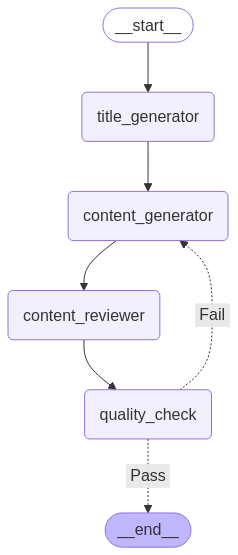

In [82]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode


builder = StateGraph(BlogState)


builder.add_node("title_generator", generate_title)
builder.add_node("content_generator", generate_content)
builder.add_node("content_reviewer", review_content)
builder.add_node("quality_check", evaluate_content)  # New evaluation node

builder.add_edge(START, "title_generator")
builder.add_edge("title_generator", "content_generator")
builder.add_edge("content_generator", "content_reviewer")
builder.add_edge("content_reviewer", "quality_check")

# Add conditional edge after quality check
builder.add_conditional_edges(
    "quality_check",
    route_based_on_verdict,
    {"Pass": END, "Fail": "content_generator"}
)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))



In [83]:
state = graph.invoke({"topic": "Langgrah Orchestrator"})
print(state["title"])
print(state["blog_content"])
print(state["reviewed_content"])
print(state["is_blog_ready"])



"Unlock Efficiency with Langgrah Orchestrator: Your Ultimate Workflow Solution"
[HumanMessage(content="### Unlock Efficiency with Langgrah Orchestrator: Your Ultimate Workflow Solution\n\nIn today’s fast-paced digital environment, every team is on the lookout for the tools that can streamline their processes, reduce redundancies, and boost productivity. Imagine a scenario where all your team’s tasks, from project management to data analysis, are seamlessly integrated and executed with maximum efficiency. Enter Langgrah Orchestrator, a sophisticated workflow management system designed to do exactly that. In this article, we will delve into how Langgrah Orchestrator can revolutionize your team’s workflow and make your daily operations smoother, more organized, and more efficient.\n\n### How Langgrah Orchestrator Works\n\nAt its core, Langgrah Orchestrator is a workflow automation tool that integrates with various applications and services to automate repetitive and time-consuming tasks. 